# 聚类分析(KMeans和DBSCAN) 


## 简介

数据集 *EV charging slot* 包含223个香港含有充电车位的停车场，本节将用这些位置数据进行聚类分析。本节主要使用机器学习包 `sklearn`来实现K-Means和DBSCAN算法. 

**Reference:**

数据集来源：www.data.gov.hk


---

## 导入数据

数据集 `charging_slots.json` 包含香港电动汽车充电站的位置信息。 

In [1]:
# 导入各种包
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_json('charging_slots.json', orient='value', encoding='UTF8')
df.head() # 观察数据集

,district-s-en,location-en,address-zh,img,district-l-en,parking-no,district-s-zh,address-en,provider,type,district-l-zh,lat-long,location-zh
1,Wong Tai Sin,Temple Mall North,"九龍黃大仙龍翔道136號,黃大仙中心北館,三樓停車場,",/EV/PublishingImages/common/map/map_thumb/Entr...,Kowloon,320-322,黃大仙,"Temple Mall North Carpark, Level 3,\n136 Lung ...",CLP,SemiQuick,九龍,"[22.342590332, 114.1907196045]",黃大仙中心北館
2,Yuen Long,Fu Shing Building,新界元朗西菁街9號富盛大廈停車場一樓,/EV/PublishingImages/common/map/map_thumb/Entr...,New Territories,33-35,元朗,"Fu Shing Building Carpark, 1/F\n9 Sai Ching St...",CLP,SemiQuick,新界,"[22.4420719147, 114.027671814]",富盛大廈
3,Wong Tai Sin,Lok Fu Plaza Carpark,九龍黃大仙橫頭磡樂富中心地下停車場,/EV/PublishingImages/common/map/map_thumb/Entr...,Kowloon,67-69,黃大仙,"Lok Fu Plaza Carpark, G/F\nWang Tau Hom, Wong ...",CLP,SemiQuick,九龍,"[22.3386573792, 114.1861038208]",樂富中心
4,Kwun Tong,MegaBox,九龍九龍灣宏照道38號MegaBox 地庫停車場,/EV/PublishingImages/common/map/map_thumb/Mega...,Kowloon,139-141,觀塘,"MegaBox Carpark, B/F\n38 Wang Chiu Road, Kowl...",CLP,SemiQuick,九龍,"[22.3203277588, 114.2085266113]",MegaBox
6,Kwai Tsing,Shek Lei Shopping Centre II,新界葵涌石籬邨石籬商場二期停車場四樓,/EV/PublishingImages/common/map/map_thumb/Entr...,New Territories,33-35,葵青區,"Shek Lei Shopping Centre Phase II Carpark, 4/...",CLP,SemiQuick,新界,"[22.3658618927, 114.14012146]",石籬商場二期


In [2]:
df.info() # 查看数据信息

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 1 to 239
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   district-s-en  223 non-null    object
 1   location-en    223 non-null    object
 2   address-zh     223 non-null    object
 3   img            98 non-null     object
 4   district-l-en  223 non-null    object
 5   parking-no     71 non-null     object
 6   district-s-zh  223 non-null    object
 7   address-en     223 non-null    object
 8   provider       223 non-null    object
 9   type           223 non-null    object
 10  district-l-zh  223 non-null    object
 11  lat-long       223 non-null    object
 12  location-zh    223 non-null    object
dtypes: object(13)
memory usage: 24.4+ KB


各项数据分别表示为：

| 名称 | 解释 |
|:--|:--|
|district-s-en|地区英文名称|
|location-en|充电槽位置的英文名称|
|address-zh |充电槽详细中文地址|
|img|图片url|
|district-l-en|大区英文名称|
|parking-no|停车位号码|
|district-s-zh|地区中文名|
|address-en|详细地址英文|
|provider|停车位供应商|
|type|充电类型|
|district-l-zh|大区中文名|
|lat-long  |位置坐标|
|location-zh|充电槽位置的中文名称|

## 计算停车位数量

仔细观察 `parking-no`, 一些停车场包含多于1个停车位，例如：

In [3]:
df.loc[1] # 观察第二个停车场

district-s-en                                         Wong Tai Sin
location-en                                      Temple Mall North
address-zh                             九龍黃大仙龍翔道136號,黃大仙中心北館,三樓停車場,
img              /EV/PublishingImages/common/map/map_thumb/Entr...
district-l-en                                              Kowloon
parking-no                                                 320-322
district-s-zh                                                  黃大仙
address-en       Temple Mall North Carpark, Level 3,\n136 Lung ...
provider                                                       CLP
type                                                     SemiQuick
district-l-zh                                                   九龍
lat-long                            [22.342590332, 114.1907196045]
location-zh                                                黃大仙中心北館
Name: 1, dtype: object

`parking-no`为320-322，说明包含3个停车位。我们需要添加一栏`no_slot`来表示停车位数量，可是大部分停车位的表示都是不规则的，不是统一格式的，这就需要我们将其进行统一格式。  

In [4]:
print(df['parking-no'].to_list())

['320-322', '33-35', '67-69', '139-141', '33-35', '1001-1003', '79-81', '1250-1251, 1305', 'B1-B3', '22-24', '33,35', 'P15-P16', '107-108', '189-190', 'B111', 'C2', 'D042 - D052, D106 - D112', '3177-3186, 3189-3206', '73-75', '2116-2119', '22, 41, 64', '121, 122', None, 'D104', '1004 -1005, 1085-1086', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '6', None, None, None, '7-10', '2094 - 2096', '258-262', '7', None, None, '1002, 1087-1089', 'P115-P120, P168', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '84', '40, 41', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None

## 定义一个统一车位格式的函数

In [5]:
# 将11-13表示为3或 D021-D031表示为11.
import re

def count_k(s):
    e = s.split('-')
    if len(e) < 2:
        return 1
    return int(e[1]) - int(e[0]) + 1

def count_parking(s):
    if s is None:
        return 1
    s = re.sub(r"[^0-9,\-]","",s) 
    slist = s.split(',')
    total = 0
    for i in slist:
        total += count_k(i)
    return total
        

df['no_slot'] = df['parking-no'].apply(count_parking)
df[['no_slot', 'parking-no']].head(20)  # 看看经过转化后前20个车位表示是否正确

,no_slot,parking-no
1,3,320-322
2,3,33-35
3,3,67-69
4,3,139-141
6,3,33-35
7,3,1001-1003
8,3,79-81
9,3,"1250-1251, 1305"
10,3,B1-B3
11,3,22-24


计算总车位数：

In [6]:
print('一共有',df['no_slot'].sum(),'个停车位。')

一共有 337 个停车位。


## 提取车位坐标
我们利用充电槽的纬度和经度进行聚类分析。首先生成223个停车场的坐标数组mylist

In [7]:
mylist = df['lat-long'].to_list()

然后，每个停车场添加各自车位数量-1个相同坐标`r['no_slot'] - 1` ，用来表示每个停车位的坐标。

In [8]:
for i, r in df.iterrows():
    for j in range(1, r['no_slot']):
        mylist.append(r['lat-long'])
mylist

[[22.342590332, 114.1907196045],
 [22.4420719147, 114.027671814],
 [22.3386573792, 114.1861038208],
 [22.3203277588, 114.2085266113],
 [22.3658618927, 114.14012146],
 [22.2882328033, 113.94190979],
 [22.5029144287, 114.1275863647],
 [22.2956161499, 114.1693572998],
 [22.4504833221, 114.1608352661],
 [22.4922847748, 114.1389007568],
 [22.3152523041, 114.1625061035],
 [22.3381347656, 114.1739120483],
 [22.3194198608, 114.1565704346],
 [22.3718738556, 113.993019104],
 [22.3010005951, 114.1679153442],
 [22.3752117157, 114.111328125],
 [22.4262580872, 114.2098770142],
 [22.4493846893, 114.0018539429],
 [22.3821163177, 114.1900787354],
 [22.3006286621, 114.1728286743],
 [22.3174228668, 114.1687316895],
 [22.2911186218, 113.943572998],
 [22.3077507019, 114.1620559692],
 [22.426361084, 114.2099151611],
 [22.3181991577, 113.9337692261],
 [22.2704715729, 114.1495437622],
 [22.2830810547, 114.1602554321],
 [22.2865810394, 114.2180328369],
 [22.2803726196, 114.226852417],
 [22.2830295563, 114.1916

最后，将mylist转化为一个`numpy`二维数组`X`，方便下面的聚类分析和可视化分析。

In [9]:
X = np.array(mylist)
print(type(X), X.shape)
print(X)

<class 'numpy.ndarray'> (337, 2)
[[ 22.34259033 114.1907196 ]
 [ 22.44207191 114.02767181]
 [ 22.33865738 114.18610382]
 [ 22.32032776 114.20852661]
 [ 22.36586189 114.14012146]
 [ 22.2882328  113.94190979]
 [ 22.50291443 114.12758636]
 [ 22.29561615 114.1693573 ]
 [ 22.45048332 114.16083527]
 [ 22.49228477 114.13890076]
 [ 22.3152523  114.1625061 ]
 [ 22.33813477 114.17391205]
 [ 22.31941986 114.15657043]
 [ 22.37187386 113.9930191 ]
 [ 22.3010006  114.16791534]
 [ 22.37521172 114.11132812]
 [ 22.42625809 114.20987701]
 [ 22.44938469 114.00185394]
 [ 22.38211632 114.19007874]
 [ 22.30062866 114.17282867]
 [ 22.31742287 114.16873169]
 [ 22.29111862 113.943573  ]
 [ 22.3077507  114.16205597]
 [ 22.42636108 114.20991516]
 [ 22.31819916 113.93376923]
 [ 22.27047157 114.14954376]
 [ 22.28308105 114.16025543]
 [ 22.28658104 114.21803284]
 [ 22.28037262 114.22685242]
 [ 22.28302956 114.19168854]
 [ 22.26245117 114.13059998]
 [ 22.24340439 114.14798737]
 [ 22.28072548 114.15458679]
 [ 22.2788

---
# K-Means算法
K-means算法通过最小化每个集群内的距离度量将数据聚类到几个独立的组中。本节使用`sklearn`包来实现该算法。 

**Reference：**[K-Means document](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) 

In [10]:
# 导入包
from sklearn.cluster import KMeans

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)  # 3个clusters
kmeans.cluster_centers_  # 看看3个clusters的坐标

array([[ 22.30316053, 114.18519197],
       [ 22.405908  , 113.98810079],
       [ 22.41616649, 114.16882621]])

In [12]:
kmeans.labels_  # 观察每个车位分别属于哪个cluster

array([0, 1, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 0, 1,
       0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, 1, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 0, 2, 1,
       2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 2,
       2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 2, 2, 2,
       2, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,

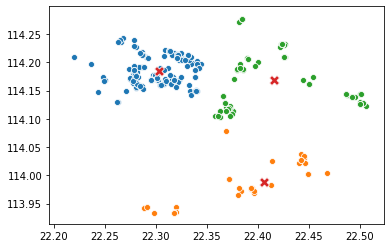

In [13]:
for i in range(3):  # 画图， 其中x表示中心
    sns.scatterplot(X[kmeans.labels_==i, 0], X[kmeans.labels_==i, 1])
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=100)

---
# DBSCAN算法
DBSCAN是聚类分析中的另一个算法。

**Reference：**[DBSCAN document](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) 

In [14]:
# 导入包
from sklearn.cluster import DBSCAN

In [15]:
dbscan = DBSCAN(eps=0.03, min_samples=3).fit(X) # 半径设为0.03，最小样本为3，clusters数随eps值改变
n_clusters = dbscan.labels_.max()+1 # 生成多少个clusters
print('DBSCAN算法生成了',n_clusters,'个clusters。')

DBSCAN算法生成了 8 个clusters。


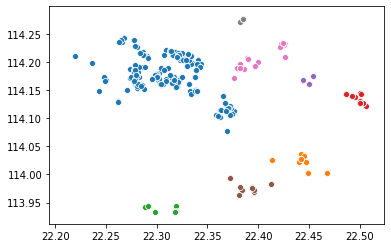

In [16]:
# 将边缘数据标为灰色
sns.scatterplot(X[dbscan.labels_==-1, 0], X[dbscan.labels_==-1, 1], color='grey')

# 不同clusters用不同颜色表示
for i in range(n_clusters):
    sns.scatterplot(X[dbscan.labels_==i, 0], X[dbscan.labels_==i, 1])